In [120]:
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp

import glob


# Combine and down-sample the original maps

The original resolution corresponds to nside = 2048, and leads to a maps.npy 50GB file.

The data-preparation and down-sampling snippets have been already executed, so feel free to jump to the next section.

In [136]:
### Example of an event

from ligo.skymap.io.fits import read_sky_map
#from astropy.io import fits

example_skymap = read_sky_map('./Data/fits/GWTC-1/GW170817_skymap.fits')
#example_skymap = fits.open('./Data/fits/GWTC-1/GW170817_skymap.fits')

example_skymap
#print(example_skymap[1].header)



(array([0., 0., 0., ..., 0., 0., 0.]),
 OrderedDict([('HISTORY',
               ['',
                'Generated by running the following script:',
                'ligo-skymap-from-samples --seed 170817 --outdir . --objid GW170817 --fit',
                'soutname MCMC_TF2_LowSpin_AllSky.fits.gz MCMC_TF2_LowSpin_AllSky_post.da',
                't']),
              ('nest', True),
              ('objid', 'GW170817'),
              ('gps_time', 1187008882.429464),
              ('gps_creation_time', 1241387534.61385),
              ('creator', 'ligo-skymap-from-samples'),
              ('origin', 'LIGO/Virgo'),
              ('distmean', 38.03408225450563),
              ('diststd', 7.499686641911211),
              ('vcs_version', 'ligo.skymap 0.0.15'),
              ('vcs_revision', '65fc6500a1e117fec2e27550a8e9b10c9792ffca'),
              ('build_date', '2018-09-04T14:19:20')]))

In [156]:
def map_prepare(fitsdir, outdir, nside = 2048):
    '''
        Load a directory full of fits skymaps from the GWOSC and output the HEALPIx maps 
        and dictionaries in outdir. Requires the ligo.skymap package. 


        Parameters
        -------
        fitsdir : string
            Path to the input directory
        outdir : string
            Path to the output directory  
        nside : int
            A valid Nside, used to downgrade the resolution of the HEALPIx maps 
    '''
    
    from tqdm import tqdm
    
    # Original fits maps contain posteriors using multiple template choices. 
    # Here we only use the a single tenplate.
    paths_1 = glob.glob(fitsdir + '/GWTC-1/*.fits')
    paths_2 = glob.glob(fitsdir + '/GWTC-2/*SEOBNRv4PHM.fits')
    paths_21 = glob.glob(fitsdir + '/GWTC-21/*SEOBNRv4PHM.fits')
    paths_3 = glob.glob(fitsdir + '/GWTC-3/*SEOBNRv4PHM.fits')
    print("Num of sources in GWTC-1 = ", len(paths_1))
    print("Num of sources in GWTC-2 = ", len(paths_2))
    print("Num of sources in GWTC-21 = ", len(paths_21))
    print("Num of sources in GWTC-3 = ", len(paths_3))
    paths = paths_1 + paths_2 + paths_21 + paths_3
    
    smaps_hr = [None]*len(paths)
    smaps = [None]*len(paths)
    dicts = [None]*len(paths)
    
    print("Loading the fits files:")
    for i, path in enumerate(tqdm(paths)):
        #print("loading ", i + 1)
        # loads the high-res maps and their headers
        smaps_hr[i], dicts[i] = read_sky_map(path)

    print("Generating the down-sampled maps:")
    for i, smap in enumerate(tqdm(smaps_hr)):
        #print("generating ", i + 1)
        # downsmaple the maps and correct the normalization
        smaps[i] = hp.pixelfunc.ud_grade(smap, nside)
        smaps[i] = smaps[i]/smaps[i].sum()

    np.save(outdir + "/maps.npy", smaps)
    np.save(outdir + "/dicts.npy", dicts)
    
    print("Process completed.")
    
    

In [157]:
# Prepare the combined calatlogue

map_prepare(fitsdir = './Data/fits/', outdir = "./Data/maps/", nside = 64)



Num of sources in GWTC-1 =  11
Num of sources in GWTC-2 =  31
Num of sources in GWTC-21 =  48
Num of sources in GWTC-3 =  36
Loading the fits files:


100%|███████████████████████████████████████████| 126/126 [00:16<00:00,  7.63it/s]


Generating the down-sampled maps:


100%|███████████████████████████████████████████| 126/126 [00:08<00:00, 15.66it/s]


Process completed.


## Using the maps


You can start directly here, since the maps and their headers are already prepared and stored.

In [159]:
        
skymaps = np.load("./Data/maps/maps.npy")
dicts = np.load("./Data/maps/dicts.npy", allow_pickle=True)


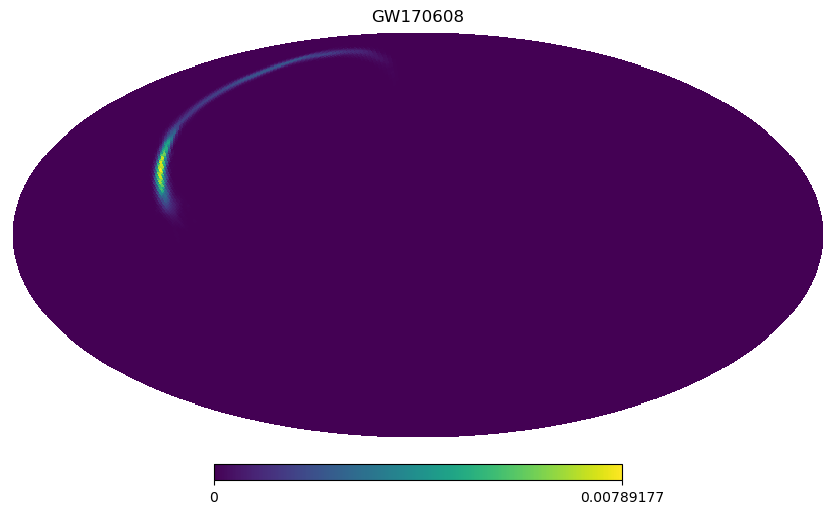

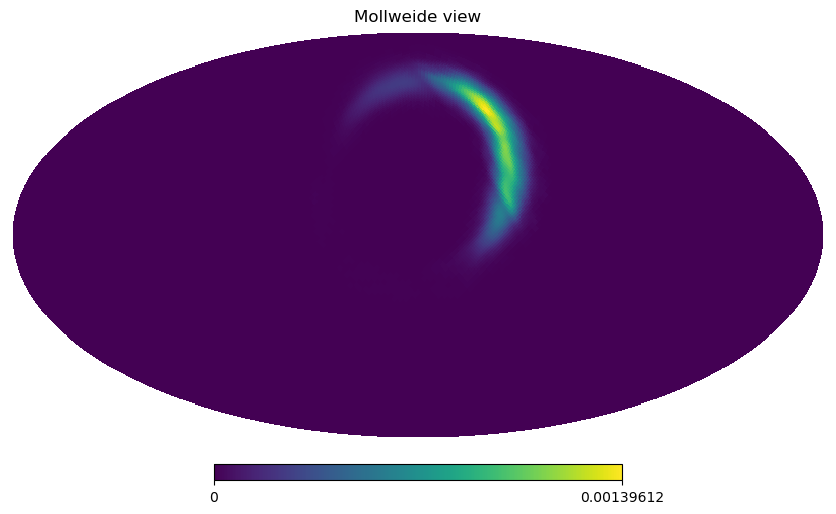

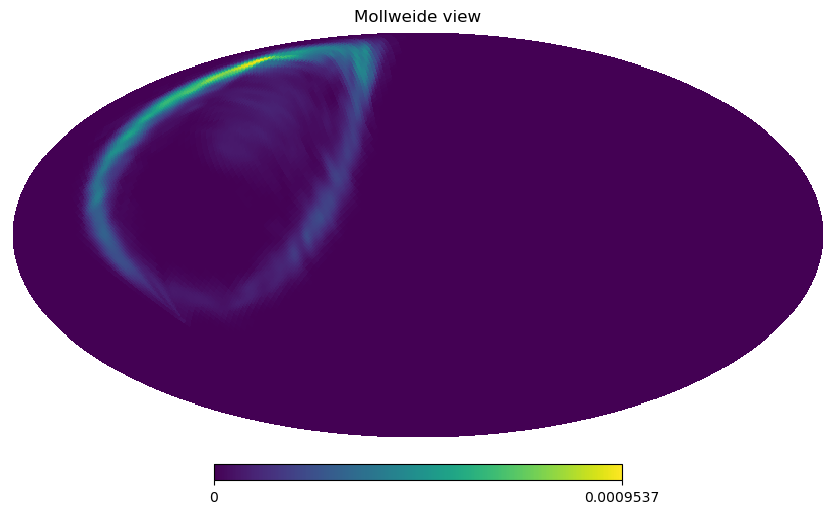

In [170]:
### Show every 50th map
for skymap_tmp, dict_tmp in zip(skymaps[0::50], dicts[0::50]):
    hp.mollview(skymap_tmp)
    
    if 'objid' in dict_tmp.keys():
        plt.title(dict_tmp['objid'])
    plt.show()
    
    

# Example on how to get RA and DEC


In [167]:
### RA and DEC in degs for a pixel with pix_index

pix_index = 100
nside = 64

theta, phi = hp.pix2ang(nside, pix_index)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)


print(ra, dec)


212.14285714285714 84.88153790222776
